In [1]:
push!(LOAD_PATH, "functions/")
using BP
using Random, Plots, SparseArrays, ITensors, Statistics, ProgressMeter, Graphs
include("ldpc_tanner_loops.jl")

In [2]:
function parity_tensor(index_arr, parity)
    num = length(index_arr)
    tens = ITensor(index_arr)
    for i in 0:(2^num - 1)
        bits = digits(i, base=2, pad=num) 
        if sum(bits) % 2 == parity
            inds_tuple = (index_arr[j] => bits[j] + 1 for j in 1:num)
            tens[inds_tuple...] = 1.0        
        end 
    end
    return tens 
end 

function get_nbrs_of_check(adj_mat, v)
    ## get nbrs of node v from adj_mat
    row = adj_mat[v, :]
    return findall(x -> x == 1, row)
end

function get_nbrs_of_data(adj_mat, v)
    ## get nbrs of node v from adj_mat
    col = adj_mat[:, v]
    return findall(x -> x == 1, col)
end

function get_network(pcmat, syndrome, pbias)
    ## pcmat: (n-k) x (n)
    ## syndrome: (n-k)
    ## close syndrome legs with given syndrome, keeps data legs open for later
    m, n = size(pcmat)
    k = n - m 
    indmat = [Index(2, "s$(i)d$(j)") for i in 1:m, j in 1:n]
    datainds = [Index(2, "x$i") for i in 1:n]
    data_tensors = []
    syn_tensors = []

    ## data data_tensors

    for i = 1:n 
        dummy = Index(2, "biasi")
        biastensor = ITensor([1-pbias, pbias],dummy)
        checks = get_nbrs_of_data(pcmat,i)
        indxs = [indmat[jj,i] for jj in checks]
        push!(indxs,dummy)
        push!(indxs,datainds[i])
        push!(data_tensors,(delta(indxs) * biastensor))
    end 

    ## check tensors 
    for j = 1:m
        datas = get_nbrs_of_check(pcmat,j)
        tensor = parity_tensor([indmat[j,ii] for ii in datas],syndrome[j])
        push!(syn_tensors,tensor)
    end 
    return data_tensors, syn_tensors, datainds
end 


function bit_to_onehot(x)
    if x == 0
        return [1, 0]
    elseif x == 1
        return [0, 1]
    elseif x == -1
        return [1/2, 1/2]
    else
        error("Input must be -1, 0, or 1")
    end
end


function get_marginal_data_tensors(data_tensors,data_indices,data_inputs;exclude=[])
    N = length(data_tensors)
    marginalized = []
    for i = 1 : N 
        if !(i in exclude)
            tens = data_tensors[i] *  ITensor(bit_to_onehot(data_inputs[i]),data_indices[i])
        else 
            tens = data_tensors[i]
        end 
        push!(marginalized,tens)
    end 
    return marginalized
end 


function sample_bit(p0)
    return rand() < p0 ? 0 : 1
end


"""
    gallager_ldpc_matrix(n::Int, d_v::Int, d_c::Int)

Generate a regular (d_v, d_c) LDPC parity-check matrix using Gallager construction.

# Arguments
- `n`: Number of bits (columns)
- `d_v`: Number of ones per column (column weight)
- `d_c`: Number of ones per row (row weight)

# Returns
- `H`: A sparse parity-check matrix of size m × n
"""
function gallager_ldpc_matrix(n::Int, d_v::Int, d_c::Int)
    # Ensure total ones are compatible
    if n * d_v % d_c != 0
        error("n*d_v must be divisible by d_c")
    end
    m = (n * d_v) ÷ d_c  # number of rows

    # Initialize empty matrix
    H = spzeros(Int8, m, n)

    # First, build the base structure
    rows_per_group = m ÷ d_v
    for i in 0:(d_v-1)
        perm = randperm(n)
        for j in 1:rows_per_group
            row = i * rows_per_group + j
            cols = perm[((j-1)*d_c + 1):(j*d_c)]
            H[row, cols] .= 1
        end
    end

    return H
end


function get_marginal(tensors,adj_mat,messages,index)
    nbrs = BP.get_nbrs(adj_mat, index)
    Z_local = tensors[index] 
    for nbr in nbrs
        Z_local *= messages[nbr,index] 
    end
    return Z_local
end 

function loop_contribution(loop, messages, tensors, edges, links, adj_mat)
    # Initialize tracking variables
    vertices_done = Set()  # Track which vertices have been processed
    loop_contri = 1        # Accumulate the loop contribution tensor product
    N = length(tensors)    # Total number of vertices in tensor network
    
    # Step 1: Process each edge in the loop
    for edge in loop
        v1, v2 = edge  # v1 < v2 by convention 
        
        # Replace BP message with excited projector P⊥ = I - μ†μ
        excitation = BP.excited_edge(edge, messages, edges, links, adj_mat)
        loop_contri *= excitation
        
        # Step 2a: Process vertex v1 (if not already done)
        if !(v1 in vertices_done)
            vertices_done = union(vertices_done, v1)
            
            # Find all vertices connected to v1 within the loop
            excited_neighbors = Set([other_vertex for edge in loop if v1 in edge for other_vertex in edge if other_vertex != v1])
            
            # Determine which indices need priming for proper tensor contraction
            edges_with_v1 = filter(t -> v1 in t, loop)  # Find loop edges containing v1
            edge_indices = [findfirst(isequal(t), edges) for t in edges_with_v1]  # Map to global edge list
            larger_bools = [v1 == max(t[1], t[2]) for t in edges_with_v1]  # v1 is larger vertex → prime needed
            selected_links = links[edge_indices[larger_bools]]  # Select indices to prime
            
            # Apply tensor T_v1 with appropriate index priming
            contri = !isempty(selected_links) ? prime(tensors[v1], selected_links...) : tensors[v1]
            loop_contri *= contri
            
            # Add BP messages from neighbors outside the loop
            for w in BP.get_nbrs(adj_mat, v1)
                current_edge = (min(v1,w), max(v1,w))  # Standard edge ordering
                edge_index = findfirst(e -> e == current_edge, edges)
                current_link = links[edge_index]
                
                # Only add message if: (1) index exists in current contraction, (2) neighbor is outside loop
                if current_link in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v1]  
                end
            end
        end
        
        # Step 2b: Process vertex v2 (if not already done) - identical logic to v1
        if !(v2 in vertices_done)
            vertices_done = union(vertices_done, v2)
            excited_neighbors = Set([other_vertex for edge in loop if v2 in edge for other_vertex in edge if other_vertex != v2])
            edges_with_v2 = filter(t -> v2 in t, loop) 
            edge_indices = [findfirst(isequal(t), edges) for t in edges_with_v2]
            larger_bools = [v2 == max(t[1], t[2]) for t in edges_with_v2]
            selected_links = links[edge_indices[larger_bools]]
            contri = !isempty(selected_links) ? prime(tensors[v2], selected_links...) : tensors[v2]
            loop_contri *= contri 

            for w in BP.get_nbrs(adj_mat, v2)
                current_edge = (min(v2,w), max(v2,w))  
                edge_index = findfirst(e -> e == current_edge, edges)
                current_link = links[edge_index]

                if current_link in inds(loop_contri) && !(w in excited_neighbors)
                    loop_contri *= messages[w,v2]  
                end
            end
        end
    end
    
    # Step 3: Contract to scalar and multiply by BP partition function on remaining vertices
    # Loop contribution (scalar) × BP partition function on vertices outside the loop
    return (loop_contri) #* mean_free_partition_fn(setdiff(Set(1:N), vertices_done), tensors, messages, edges, links, adj_mat)
end

function tensorargmax(probs)
    ix = inds(probs)[1]
    probs = [real((probs)[ix=>n]) for n in 1:dim(ix)]
    probs ./= sum(probs)
    return Int(argmax(probs)-1) #sample_bit(probs[1])
end 

function tensornormlist(probs)
    ix = inds(probs)[1]
    probs = [real((probs)[ix=>n]) for n in 1:dim(ix)]
    probs ./= sum(probs)
    return probs
end 


tensornormlist (generic function with 1 method)

In [3]:
function plot_tanner_graph(H::Matrix{Int})
    m, n = size(H)  # m parity checks, n variables
    
    # Create a simple plot using Plots.jl
    fig = plot(size=(800, 600), aspect_ratio=:equal, 
               title="Tanner Graph", legend=false,
               xlims=(-0.5, 2.5), ylims=(-0.5, max(m, n) + 0.5),
               axis=false, showaxis=false, grid=false)
    
    # Position data nodes on the right
    data_x = fill(2.0, n)
    data_y = collect(0:(n-1)) .* (max(m, n) - 1) / max(n - 1, 1)
    
    # Position check nodes on the left  
    check_x = fill(0.0, m)
    check_y = collect(0:(m-1)) .* (max(m, n) - 1) / max(m - 1, 1)
    
    # Draw edges first (behind nodes)
    for i in 1:m
        for j in 1:n
            if H[i, j] == 1
                plot!(fig, [check_x[i], data_x[j]], [check_y[i], data_y[j]], 
                      color=:gray, linewidth=1, alpha=0.6)
            end
        end
    end
    
    # Draw check nodes (squares on left)
    scatter!(fig, check_x, check_y, 
            color=:lightgreen, marker=:square, markersize=8,
            markerstrokewidth=2, markerstrokecolor=:darkgreen)
    
    # Draw data nodes (circles on right)
    scatter!(fig, data_x, data_y, 
            color=:lightblue, marker=:circle, markersize=8,
            markerstrokewidth=2, markerstrokecolor=:darkblue)
    
    # Add labels
    for i in 1:m
        annotate!(fig, check_x[i] - 0.15, check_y[i], text("c$i", :right, 8))
    end
    
    for j in 1:n
        annotate!(fig, data_x[j] + 0.15, data_y[j], text("x$j", :left, 8))
    end
    
    return fig
end

function sample_weight_w_error(n::Int, w::Int)
    @assert 0 ≤ w ≤ n "w must be between 0 and n"
    e = zeros(Int, n)
    w == 0 && return e
    idx = randperm(n)[1:w]
    e[idx] .= 1
    return e
end

# examples:
# weight-1 error on n bits
# errors_true = sample_weight_w_error(n, 1)
# weight-w error
#

sample_weight_w_error (generic function with 1 method)

In [4]:
module BCH
export parity_check

# Primitive polynomials for GF(2^m) as Ints (avoid UInt to prevent method errors)
const PRIMITIVE_POLYS = Dict{Int,Int}(
    2  => 0b111,                      # x^2 + x + 1
    3  => 0b1011,                     # x^3 + x + 1
    4  => 0b10011,                    # x^4 + x + 1
    5  => 0b100101,                   # x^5 + x^2 + 1
    6  => 0b10000011,                 # x^6 + x + 1
    7  => 0b10000011,                 # x^7 + x + 1
    8  => 0b1_0001_1101,              # x^8 + x^4 + x^3 + x^2 + 1 (285)
    9  => 0b10_0001_0001,             # x^9 + x^4 + 1
    10 => 0b100_0000_1001,            # x^10 + x^3 + 1
    11 => 0b1_0000_0000_101,          # x^11 + x^2 + 1
    12 => 0b1_0001_0100_0011,         # x^12 + x^6 + x^4 + x + 1
    13 => 0b1_0000_0001_1011,         # x^13 + x^4 + x^3 + x + 1
    14 => 0b100_0100_0000_0011,       # x^14 + x^10 + x^6 + x + 1
    15 => 0b1_0000_0000_0000_11,      # x^15 + x + 1
    16 => 0b1_0001_0000_0000_1011     # x^16 + x^12 + x^3 + x + 1
)

# exp/log tables for GF(2^m)
function gf2m_tables(m::Int, prim::Int)
    n = (1 << m) - 1
    exp = Vector{Int}(undef, n)
    log = fill(-1, 1 << m)
    x = 1
    prim_lower = prim & ((1 << m) - 1)  # drop x^m term
    for i in 0:(n - 1)
        exp[i + 1] = x
        log[x + 1] = i
        x <<= 1
        if (x & (1 << m)) != 0
            x = (x & ((1 << m) - 1)) ⊻ prim_lower
        end
    end
    return exp, log
end

@inline gf2m_pow(exp::Vector{Int}, k::Int, n::Int) = exp[(mod(k, n)) + 1]

# Cyclotomic coset leaders among {1..2t} modulo n (base 2)
function bch_coset_leaders(n::Int, m::Int, t::Int)
    seen = falses(n)
    leaders = Int[]
    for a in 1:min(2t, n - 1)
        seen[a + 1] && continue
        c = Int[]
        x = a
        while !seen[x + 1]
            push!(c, x)
            seen[x + 1] = true
            x = mod(2x, n)
        end
        if minimum(c) == a
            push!(leaders, a)
        end
    end
    sort!(leaders)
    return leaders
end

# Row-reduction over GF(2)
function gf2_row_reduce(H::Matrix{Int})
    H = copy(H)
    r, c = 1, 1
    m, n = size(H)
    while r <= m && c <= n
        pivot = findfirst(i -> H[i, c] == 1, r:m)
        if pivot === nothing
            c += 1
            continue
        end
        if pivot != r
            H[r, :], H[pivot, :] = H[pivot, :], H[r, :]
        end
        for i in 1:m
            if i != r && H[i, c] == 1
                @inbounds @simd for j in c:n
                    H[i, j] = H[i, j] ⊻ H[r, j]
                end
            end
        end
        r += 1; c += 1
    end
    keep = [any(H[i, :] .== 1) for i in 1:m]
    return H[keep, :]
end

# Public API: build BCH parity-check matrix H for given m, t
function parity_check(m::Int, t::Int; reduce::Bool = true)
    @assert m ≥ 2 "m must be ≥ 2"
    n = (1 << m) - 1
    @assert 1 ≤ t < n ÷ 2 "t must be in [1, (n-1)/2]"
    prim = get(PRIMITIVE_POLYS, m, nothing)
    prim !== nothing || error("No primitive polynomial known for m=$m.")
    exp, _ = gf2m_tables(m, Int(prim))

    leaders = bch_coset_leaders(n, m, t)

    H = Array{Int}(undef, 0, n)
    for a in leaders
        block = zeros(Int, m, n)
        for j in 0:(n - 1)
            elem = gf2m_pow(exp, a * j, n)  # in [0, 2^m-1]
            for bit = 0:(m - 1)
                block[bit + 1, j + 1] = (elem >> bit) & 0x1
            end
        end
        H = vcat(H, block)
    end
    return reduce ? gf2_row_reduce(H) : H
end

end # module BCH

# Example usage in this notebook:
m = 4; t = 2
H = BCH.parity_check(m, t)
size(H)  # (n-k) × n

(8, 15)

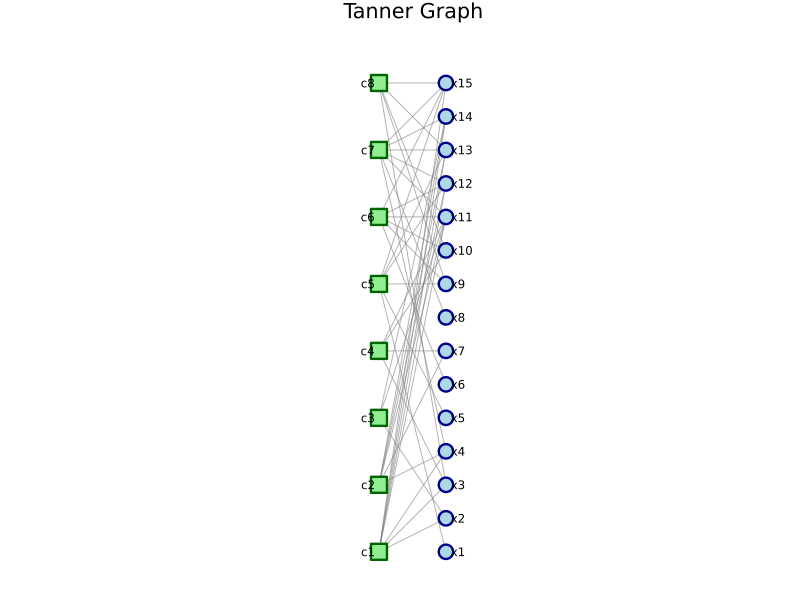

In [6]:
plot_tanner_graph(H)

In [7]:
# ...existing code...
function loops_through_two_errors(H::AbstractMatrix{<:Integer}, errors::AbstractVector{<:Integer}; max_length::Int=8)
    m, n = size(H)
    err_bits = collect(findall(==(1), errors))
    @assert length(err_bits) == 2 "errors must be weight-2"

    loops1 = find_tanner_loops(H, err_bits[1]; max_length=max_length)
    loops_both = filter(L -> err_bits[2] in L.data_bits, loops1)

    order_edge(e::Tuple{Int,Int}) = (min(e[1], e[2]), max(e[1], e[2]))

    # canonical key (immutable) for dedup up to rotation and reversal
    function canon_loop(edges_vec::Vector{Tuple{Int,Int}})
        k = length(edges_vec)
        k == 0 && return ()
        rotations = [circshift(edges_vec, i) for i in 0:k-1]
        rev = reverse(edges_vec)
        rotations_rev = [circshift(rev, i) for i in 0:k-1]
        candidates = [Tuple([order_edge(e) for e in r]) for r in vcat(rotations, rotations_rev)]
        return minimum(candidates)
    end

    seen = Set{Tuple{Vararg{Tuple{Int,Int}}}}()
    result = NamedTuple[]

    for L in loops_both
        edges_ord = [order_edge(e) for e in L.edges]          # enforce v < w
        key = canon_loop(edges_ord)
        if !(key in seen)
            push!(seen, key)
            push!(result, (edges=edges_ord, data_bits=L.data_bits, check_bits=L.check_bits))
        end
    end
    return result
end
#

loops_through_two_errors (generic function with 1 method)

In [42]:
m, n = size(H)
k = n - m
pbias = 0.2
max_loop_order = 10

10

In [44]:
# Sample e"rrors iid with probability p
errors_true = sample_weight_w_error(n,2)
# Compute syndrome
syndrome = H * errors_true .% 2;
collect(findall(==(1), errors_true))
loops_through_two_errors(H,errors_true;max_length=max_loop_order)

68-element Vector{NamedTuple}:
 (edges = [(3, 16), (13, 16), (13, 20), (15, 20), (15, 23), (3, 23)], data_bits = Set([13, 15, 3]), check_bits = Set([5, 8, 1]))
 (edges = [(3, 16), (13, 16), (13, 22), (15, 22), (15, 23), (3, 23)], data_bits = Set([13, 15, 3]), check_bits = Set([7, 8, 1]))
 (edges = [(4, 16), (15, 16), (15, 20), (13, 20), (13, 17), (4, 17)], data_bits = Set([4, 15, 13]), check_bits = Set([5, 2, 1]))
 (edges = [(4, 16), (15, 16), (15, 22), (13, 22), (13, 17), (4, 17)], data_bits = Set([4, 15, 13]), check_bits = Set([7, 2, 1]))
 (edges = [(4, 16), (15, 16), (15, 23), (13, 23), (13, 17), (4, 17)], data_bits = Set([4, 15, 13]), check_bits = Set([2, 8, 1]))
 (edges = [(4, 16), (13, 16), (13, 20), (15, 20), (15, 22), (4, 22)], data_bits = Set([4, 13, 15]), check_bits = Set([5, 7, 1]))
 (edges = [(4, 16), (13, 16), (13, 23), (15, 23), (15, 22), (4, 22)], data_bits = Set([4, 13, 15]), check_bits = Set([7, 8, 1]))
 (edges = [(4, 17), (13, 17), (13, 20), (15, 20), (15, 22), (4, 22

In [45]:
tannerloopslist = [find_tanner_loops(H, d; max_length=max_loop_order) for d in 1:n];# commonloops = loops_through_two_errors(H,errors_true;max_length=max_loop_order);

In [ ]:
## method2
data_tensors, syn_tensors, data_indices = get_network(H, syndrome, pbias)
errors = Int.(-1 .* ones(n))
tensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors), syn_tensors)
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links) 
messages = BP.message_passing(tensors,messages,edges,links,adj_mat;α=0.95, max_iters=500,diagnose=false,normalise=true)

err_bits = collect(findall(==(1), errors_true))  # only correct on these bits


for d = 1:n 
    probs = (get_marginal(vcat(data_tensors,syn_tensors),adj_mat,messages,d))
    vacuum = tensorargmax(probs)

    # if d in err_bits
    #     probs *= 0 
    # end 

    tannerloops = tannerloopslist[d]
    loop_list = [tannerloop.edges for tannerloop in tannerloops] 
    data_bits_involved_list = [tannerloop.data_bits for tannerloop in tannerloops]
    check_bits_involved_list = [tannerloop.check_bits for tannerloop in tannerloops]
    loopprobs = ITensor([0,0], data_indices[d])
    for (i, loop) in enumerate(loop_list)
        data_bits_involved = data_bits_involved_list[i] 
        check_bits_involved = check_bits_involved_list[i] 
        mtensors = vcat(get_marginal_data_tensors(data_tensors, data_indices, errors; exclude=[d]), syn_tensors)
        normlz1 = scalar(prod([get_marginal(mtensors,adj_mat,messages,other_data_bit) for other_data_bit in collect(setdiff(data_bits_involved, [d]))]))
        normlz2 = scalar(prod([get_marginal(mtensors,adj_mat,messages,n+check_bit) for check_bit in check_bits_involved]))
        normlz = normlz1 * normlz2
        change = loop_contribution(loop, messages, mtensors, edges, links, adj_mat) / normlz
        loopprobs += change 
    end
    if d in err_bits 
        println(probs)
        println(loopprobs)
    end 
    loopcorr = tensorargmax(probs + loopprobs)
    error_i = loopcorr
    if vacuum != loopcorr 
        println("loopcorr at ", d)
    end

    errors[d] = error_i
    if errors[d] != errors_true[d]
        println("failed at ", d)
        break 
    end 
end


residual = (errors .+ errors_true) .% 2
if sum(residual) != 0
    println("failed")
else 
    println("passed")
end

ITensor ord=1
Dim 1: (dim=2|id=286|"x13")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2-element
  0.14201386876281144 + 0.0im
 0.031191029395653307 + 0.0im
ITensor ord=1
Dim 1: (dim=2|id=286|"x13")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2-element
  0.003124168748286577 + 0.0im
 -0.021439277351609665 + 0.0im
failed at 13
passed
